# **Cálculo de conectividades clásicas**

1. Creación de señal arbitraria de EEG

In [28]:
import numpy as np

channels = ['Fp1','Fpz','Fp2',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'C5','C3','C1','Cz','C2','C4','C6',
            'P7', 'P3','P1','Pz','P2','P4','P8',
            'O1','Oz','O2',
            'Iz']

areas = {
    'Frontal': ['Fpz', 'Fz'],
    'Frontal Right': ['Fp2', 'F2', 'F4', 'F6', 'F8'],
    'Central Right': ['C2', 'C4', 'C6'],
    'Posterior Right': ['P2', 'P4', 'P8', 'O2'],
    'Posterior': ['Pz', 'Cz', 'Oz', 'Iz'],
    'Posterior Left': ['P1', 'P3', 'P7', 'O1'],
    'Central Left': ['C1', 'C3', 'C5'],
    'Frontal Left': ['Fp1', 'F1', 'F3', 'F5', 'F7']
}

n_channels = len(channels)
duration_sec = 4
sampling_rate = 250
n_samples = duration_sec * sampling_rate

np.random.seed(42)  # Establece la semilla
eeg = np.random.randn(n_channels, n_samples)

2. Cálculo de conectividades: correlación, covarianza, coherencia e información mutua

In [29]:
# Correlación  

corr_matrix = np.corrcoef(eeg)

In [30]:
# Covarianza

cov_matrix = np.cov(eeg)

In [31]:
# Coherencia

from scipy.signal import coherence

coh_matrix = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(i, n_channels):
        f, Cxy = coherence(eeg[i], eeg[j], fs=sampling_rate)
        coh_value = np.mean(Cxy)  # Promedio en todas las frecuencias
        coh_matrix[i, j] = coh_value
        coh_matrix[j, i] = coh_value  # simétrica

In [32]:
# Información mutua

from sklearn.neighbors import KernelDensity

def compute_mi_gaussian_kernel(x, y, bandwidth=0.2):
    xy = np.vstack([x, y]).T  # shape (T, 2)

    # Estimate densities
    kde_joint = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xy)
    kde_x = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x.reshape(-1, 1))
    kde_y = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y.reshape(-1, 1))

    # Evaluate log densities at sample points
    log_pxy = kde_joint.score_samples(xy)
    log_px = kde_x.score_samples(x.reshape(-1, 1))
    log_py = kde_y.score_samples(y.reshape(-1, 1))

    # Compute MI
    mi = np.mean(log_pxy - log_px - log_py)
    return mi

def compute_mi_matrix(data, bandwidth=0.2):
    n_channels = data.shape[0]
    mi_mat = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i, n_channels):
            mi = compute_mi_gaussian_kernel(data[i], data[j], bandwidth=bandwidth)
            mi_mat[i, j] = mi
            mi_mat[j, i] = mi  # symmetric
            if i==j:
                mi_mat[i,j]=0

    return mi_mat


mi_matrix = compute_mi_matrix(eeg, bandwidth=0.5)

In [33]:
connectivities = {
    'correlation': corr_matrix,
    'covariance': cov_matrix,
    'coherence': coh_matrix,
    'mutual_information': mi_matrix
}

# **Visualización de conectividades**

In [34]:
# Escojamos una de las conectividades a ilustrar
relations = connectivities['correlation']

## **Circunplot**

In [35]:
pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-zwchawmh
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-zwchawmh
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit 162dbeac141a7472d3b0bd7f005932241b4663a5
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [36]:
from gcpds.visualizations.connectivities import CircosConnectivity
import matplotlib.pyplot as plt

def plot_circos(connectivities, eeg_ch_names, areas, threshold=0.6):
    """
    input
    connectivities: tensorflow square array
    """
    conn = CircosConnectivity(connectivities, eeg_ch_names, areas=areas, threshold=threshold,
    # cmaps and themes
    areas_cmap='Set3',
    arcs_cmap='Wistia',
    hemisphere_color='lightgray',
    channel_color='#f8f9fa',
    min_alpha=0,
    # Texts
    width={'hemispheres':35, 'areas':100, 'channels':60},
    text={'hemispheres':40, 'areas':20,  'channels':40},
    separation={'hemispheres':10, 'areas':-30, 'channels':5},
    labelposition={'hemispheres':60, 'areas':0, 'channels':-10},
    size=5,
    labelsize=6,
    # Shapes
    show_emisphere=True,
    arcs_separation=30,
    connection_width=0.1,
    small_separation=5,
    big_separation=10,
    offset=0,
    )
    plt.show()


gráfica estática

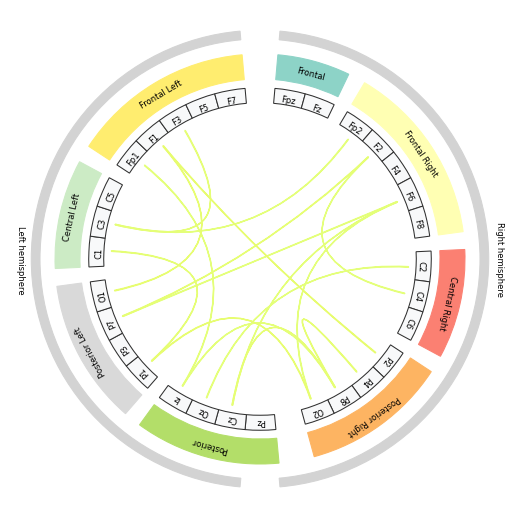

In [43]:
plot_circos(relations, channels, areas, threshold=0.06)

gráfica con deslizante en el umbral

In [38]:
!pip install ipywidgets

In [42]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget para el threshold
threshold_widget = widgets.BoundedFloatText(
    value=0.06,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Threshold:',
    disabled=False
)

# Botones
button_increase = widgets.Button(description='+0.01')
button_decrease = widgets.Button(description='-0.01')

# Salida del gráfico
output = widgets.Output()

# Función que actualiza el gráfico
def update_plot(_=None):
    with output:
        clear_output(wait=True)
        plot_circos(
            connectivities=relations,
            eeg_ch_names=channels,
            areas=areas,
            threshold=threshold_widget.value
        )

# Botones ahora también llaman a update_plot()
def increase_threshold(_):
    if threshold_widget.value + 0.01 <= threshold_widget.max:
        threshold_widget.value += 0.01
        update_plot()

def decrease_threshold(_):
    if threshold_widget.value - 0.01 >= threshold_widget.min:
        threshold_widget.value -= 0.01
        update_plot()

# Enlazar eventos
button_increase.on_click(increase_threshold)
button_decrease.on_click(decrease_threshold)
threshold_widget.observe(update_plot, names='value')  # Solo útil si escribes manualmente

# Mostrar controles y resultado
controls = widgets.HBox([threshold_widget, button_decrease, button_increase])
display(controls, output)

# Primer render
update_plot()


Output()

## **Topoplot**

In [40]:
import mne

def topoplot(data, channels, montage_name='standard_1020', ax=None, contours=None, colorbar=True, **kwargs):
    """
    Plots a topomap of EEG data.
    Parameters:
    data: array-like
        The data values for each channel.
    channels: list of str
        The names of the EEG channels.
    montage_name: str
        The name of the montage to use for the topomap. Default is 'standard_1020'.
    ax: matplotlib.axes.Axes
        The axes object to plot the topomap on. If None, a new axes will be created.
    contours: int or array-like
        The number of contour levels to draw, or the specific levels to draw.
    **kwargs: dict
        Additional keyword arguments to pass to mne.viz.plot_topomap.
    Returns:
    im: matplotlib.image.AxesImage
        The image object created by mne.viz.plot_topomap.
    """
    info = mne.create_info(channels, sfreq=1, ch_types="eeg")
    info.set_montage(montage_name)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im, _ = mne.viz.plot_topomap(data, info, axes=ax, contours=contours, show=False, **kwargs)

    if colorbar:
    # Add the colorbar
        fig.colorbar(im, ax=ax)

    return im

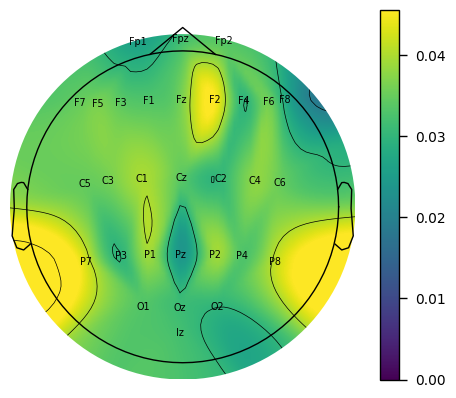

In [41]:
topoplot(np.mean(relations, axis=1), channels, contours=3, names=channels, sensors=False, cmap='viridis')
plt.show()